In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

prices = pd.read_excel('data/generated_average_prices.xlsx')
precipitations = pd.read_excel('data/weather_merignac.xlsx', sheet_name='precipitations_mm', index_col=0)
temp_maximals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_maximals', index_col=0)
temp_minimals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_minimals', index_col=0)
frost_days = pd.read_excel('data/weather_merignac.xlsx', sheet_name='frost_days_count', index_col=0)
insulation = pd.read_excel('data/weather_merignac.xlsx', sheet_name='insulation', index_col=0)

According to 'The Demand for Expert Opinion: Bordeaux Wine', some important factors are:
- Age of Wine
- Average temperature in the summer (Apr-Sep)
- Harvest rain (Aug-Sep)
- Winter rain (Oct-Mar)

We are going to try and recreate the results of the regression that was run in the paper.

# Feature engineering - recreating the Ashenfelter experiment

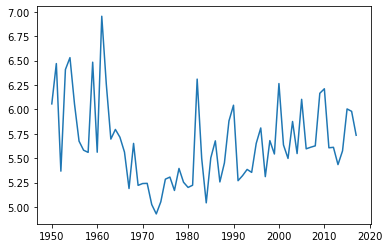

In [2]:
y = prices.set_index('Vintage', drop=True)[['Log Price']]
sns.lineplot(data=y['Log Price'])
plt.show()

In [170]:
X = pd.DataFrame(index = precipitations.index)
X['Harvest Rain'] = precipitations['Aou'] + precipitations['Sep']

X['Winter Rain'] = precipitations.shift(1)['Oct'] + precipitations.shift(1)['Nov']\
+ precipitations.shift(1)['Dec'] + precipitations['Jan']+ precipitations['Fev'] + precipitations['Mar']

X['Summer Temperature'] = (temp_maximals['Avr'] + temp_maximals['Mai'] + temp_maximals['Jui'] + temp_maximals['Juil']\
+ temp_maximals['Aou'] + temp_maximals['Sep'] + temp_minimals['Avr'] + temp_minimals['Mai'] + temp_minimals['Jui'] + temp_minimals['Juil']\
+ temp_minimals['Aou'] + temp_minimals['Sep']) / 12

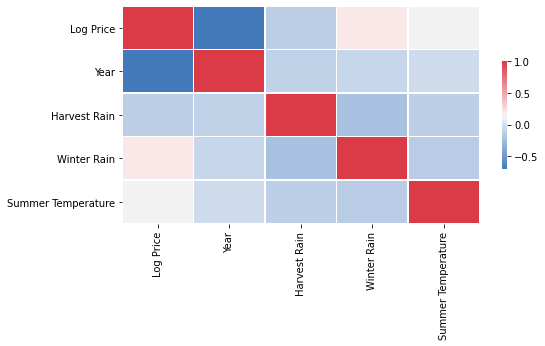

In [4]:
oldest_vintage=1950
newest_vintage=1980
y_ex = y.loc[oldest_vintage:newest_vintage+1,:].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
combined = pd.concat([y_ex[['Log Price']], X_ex], axis=1)
corr = combined.corr()

plt.figure(figsize=(8,4))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap, linewidth=.5, cbar_kws={"shrink": .5})
plt.show()

## Building the model

In [5]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(normalize=False)
oldest_vintage=1950
newest_vintage=1980

y_ex = y.loc[oldest_vintage:newest_vintage+1,'Log Price'].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
model.fit(X_ex, y_ex)
for i in range(len(X_ex.columns.to_list())):  
    print(X_ex.columns.to_list()[i], model.coef_[i])
print('Model Score: ',model.score(X_ex,y_ex))

Year -0.0388968218823763
Harvest Rain -0.0012086551317579987
Winter Rain 0.0005620921563760743
Summer Temperature 0.0818143206324637
Model Score:  0.5543329688907064


This score is quite good, but not as impressive as in the first experiment. This could be due to several factors: the prices were not gathered the same way, the corpus of wines is different, the prices have changed since the experiment. Let us now try to see how this modelss result have changed over time.

In [46]:
from sklearn.preprocessing import StandardScaler

def model_tester(X, y):
    coefficients = pd.DataFrame(0, index = ['Year']+X.columns.to_list(), columns=range(1950,1985))
    scores = []
    X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)

    for column in coefficients:
        oldest_vintage = column
        newest_vintage = column + 30

        y_ex = y.loc[oldest_vintage:newest_vintage+1,'Log Price'].reset_index(drop=True)
        X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()

        model.fit(X_ex,y_ex)
        coefs = pd.Series(model.coef_)
        coefs.index = coefficients.index
        coefficients[column] = coefs
        scores.append(model.score(X_ex,y_ex))
    
    coefficients = coefficients.transpose()
    display(coefficients.head())
    return coefficients, scores


#We will need ticks correspoding to our rolling windows for the graphs
labels = [str(i)+'-'+str(i+30) for i in range(1950,1986,5)]

,Year,Harvest Rain,Winter Rain,Summer Temperature,Late Summer Temperature
1950,-0.046106,-0.052818,-0.017703,-0.069044,0.342688
1951,-0.037553,-0.047488,0.100907,0.008129,0.316728
1952,-0.034979,-0.057442,0.097022,0.020062,0.322163
1953,-0.037008,-0.073952,0.098563,0.074556,0.264535
1954,-0.036076,-0.077308,0.095334,0.072154,0.277552


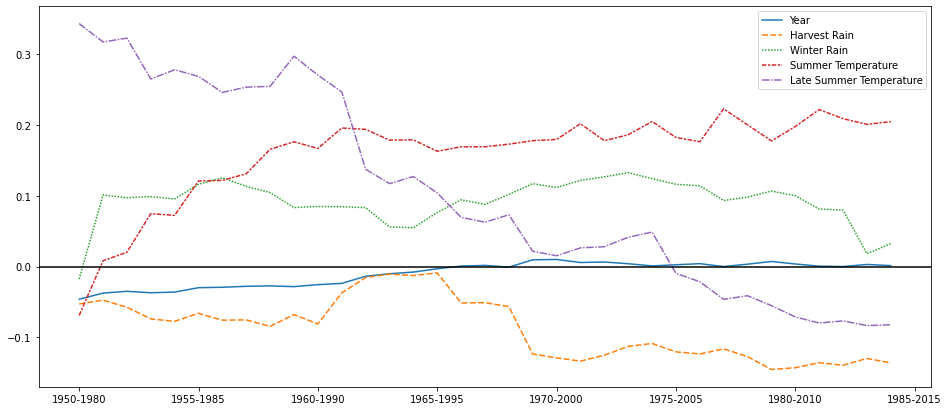

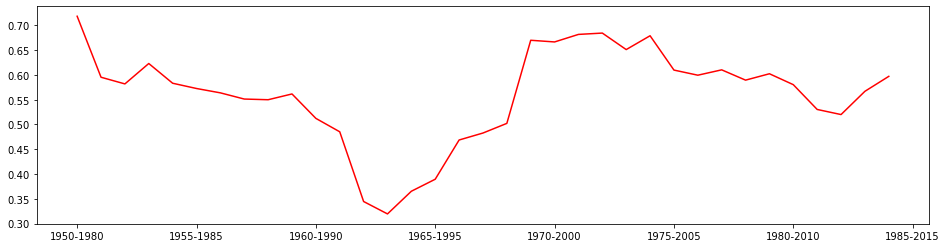

Average score over the whole period:  0.5602449201273497


In [47]:
coefficients, scores = model_tester(X, y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients).axhline(0., color='black')
plt.xticks(range(1950,1986,5),labels=labels)
plt.show()
   
plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.xticks(range(0,36,5),labels=labels)
plt.show()
print('Average score over the whole period: ',np.mean(scores))

# Adding new variables

In [8]:
X = pd.DataFrame(index = precipitations.index)

X['Harvest Rain'] = precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou'] + precipitations['Sep']
X['Spring Rain'] = precipitations['Mar']+precipitations['Avr']

X['Winter Rain'] = precipitations.shift(1)['Oct'] + precipitations.shift(1)['Nov']\
+ precipitations.shift(1)['Dec'] + precipitations['Jan']+ precipitations['Fev'] + precipitations['Mar']

X['Insulation'] = insulation.iloc[:,0]

X['Winter Temperature'] = \
    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
    (temp_maximals['Fev'] + temp_minimals['Fev'])+\
    (temp_maximals['Mar'] + temp_minimals['Mar'])
X['Early Summer Temperature'] = \
    (temp_maximals['Avr'] + temp_minimals['Avr']) +\
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui']) +\
    (temp_maximals['Juil'] + temp_minimals['Juil'])

X['Late Summer Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])

X['Frost Days Winter'] = frost_days.shift(1)['Nov']+frost_days.shift(1)['Dec'] + frost_days['Jan']
X['Frost Days Early'] = frost_days['Fev']+frost_days['Mar']
X['Frost Days Late'] = frost_days['Avr']+ 2*(frost_days['Mai'] + frost_days['Jui'] + frost_days['Juil'])

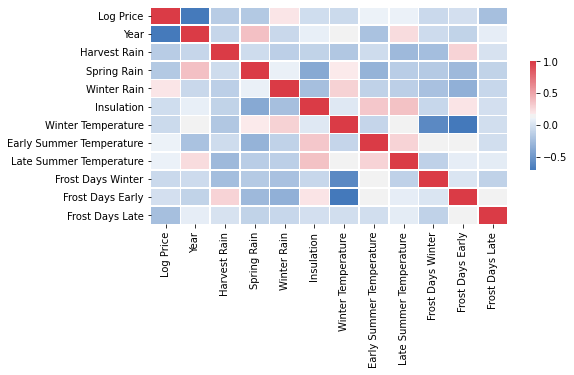

In [9]:
y_ex = y.loc[oldest_vintage:newest_vintage+1,:].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
combined = pd.concat([y_ex[['Log Price']], X_ex], axis=1)

corr = combined.corr()

plt.figure(figsize=(8,4))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap, linewidth=.5, cbar_kws={"shrink": .5})
plt.show()

,Year,Harvest Rain,Spring Rain,Winter Rain,Insulation,Winter Temperature,Early Summer Temperature,Late Summer Temperature,Frost Days Winter,Frost Days Early,Frost Days Late
1950,-0.403148,-0.088540,0.036882,0.053040,0.013982,-0.256852,-0.038199,0.173829,-0.183917,-0.171288,-0.093320
1951,-0.308965,-0.092523,-0.039863,0.060369,-0.029326,-0.378738,0.045015,0.149921,-0.312178,-0.286452,-0.128025
1952,-0.307980,-0.092141,-0.043533,0.049280,-0.011164,-0.366192,0.038490,0.144965,-0.311223,-0.288260,-0.125069
1953,-0.364927,-0.108425,-0.023257,0.065991,-0.070309,-0.200801,0.116682,0.103530,-0.203452,-0.163036,-0.086296
1954,-0.341873,-0.108806,-0.017307,0.050857,-0.048310,-0.254165,0.108426,0.099829,-0.235361,-0.206118,-0.092492


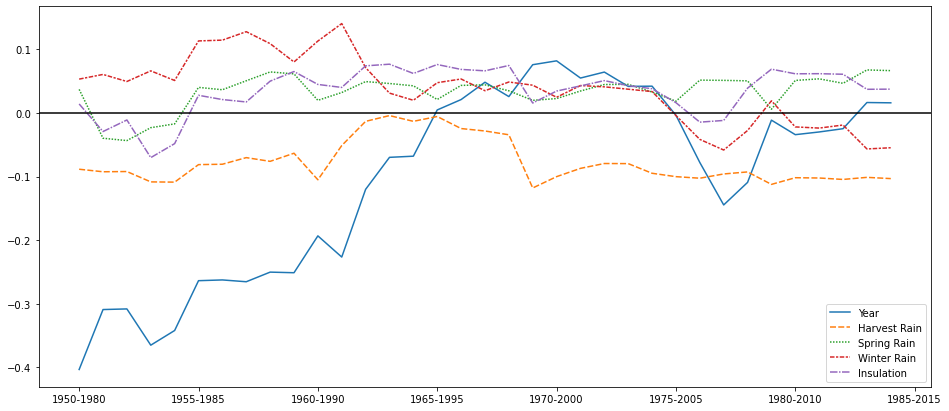

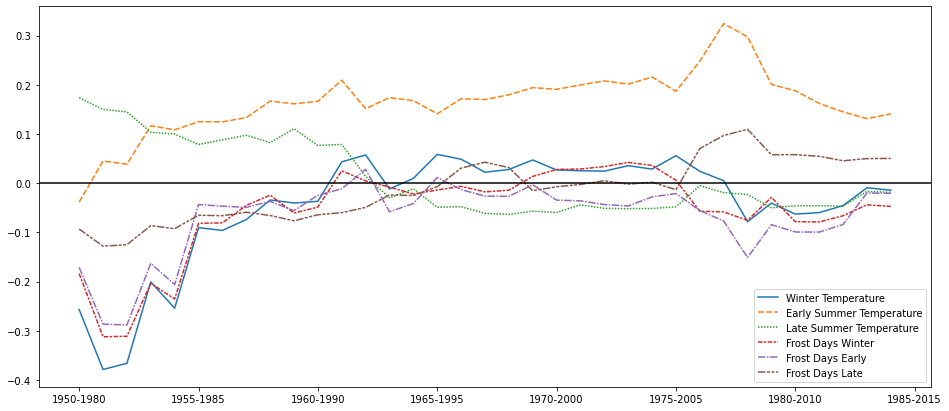

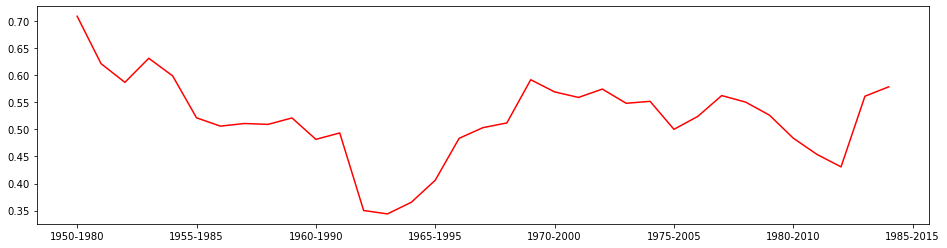

Average score over the whole period:  0.5206676896635257


In [10]:
coefficients, scores = model_tester(X,y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,:5]).axhline(0., color='black')
plt.xticks(range(1950,1986,5),labels=labels)
plt.show()

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,5:]).axhline(0., color='black')
plt.xticks(range(1950,1986,5),labels=labels)
plt.show()
   
plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.xticks(range(0,36,5),labels=labels)
plt.show()
print('Average score over the whole period: ',np.mean(scores))

This is better, but there is too many features: 11 features for predicting a 30 dimensional vector.
Let us rank the features according to their average importance.

In [11]:
df = coefficients
rank = np.mean(np.abs(df)).to_frame()
rank.columns = ['Importance']
rank = rank.sort_values('Importance', ascending=False)
display(rank)

,Importance
Early Summer Temperature,0.166349
Year,0.132123
Harvest Rain,0.077704
Winter Temperature,0.076907
Frost Days Early,0.071212
Frost Days Winter,0.069205
Late Summer Temperature,0.062726
Winter Rain,0.055192
Frost Days Late,0.052358
Insulation,0.044755


# Improved model

In [174]:
X = pd.DataFrame(index = precipitations.index)

X['Harvest Rain'] =  precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou']+ precipitations['Sep']*2

X['Winter Rain'] =  precipitations.shift(1)['Dec']

#X['Winter Temperature'] = \
#    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
#    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
#    (temp_maximals['Fev'] + temp_minimals['Fev'])


X['Summer Temperature'] = \
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui'])*2+\
    (temp_maximals['Juil'] + temp_minimals['Juil'])

X['Late Summer Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])*3+\
                    (temp_maximals['Oct'] + temp_minimals['Oct'])*2


#X['Frost Days'] = frost_days['Mar']+ 2*frost_days['Avr']+ 3*(frost_days['Mai'] + frost_days['Jui'])

,Year,Harvest Rain,Winter Rain,Summer Temperature,Late Summer Temperature
1950,-0.046106,-0.052818,-0.017703,-0.069044,0.342688
1951,-0.037553,-0.047488,0.100907,0.008129,0.316728
1952,-0.034979,-0.057442,0.097022,0.020062,0.322163
1953,-0.037008,-0.073952,0.098563,0.074556,0.264535
1954,-0.036076,-0.077308,0.095334,0.072154,0.277552


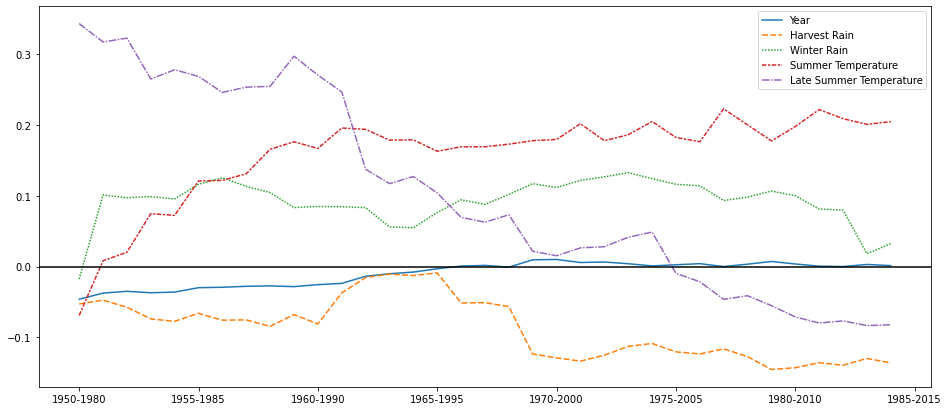

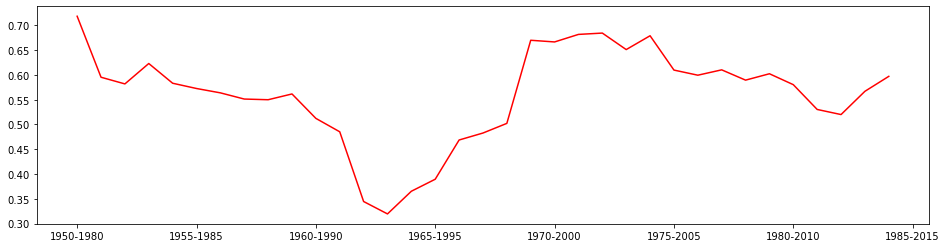

Average score over the whole period:  0.5602449201273497


In [66]:
coefficients, scores = model_tester(X, y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,:]).axhline(0., color='black')
plt.xticks(range(1950,1986,5),labels=labels)
plt.show()

plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.xticks(range(0,36,5),labels=labels)
plt.show()
print('Average score over the whole period: ',np.mean(scores))

# Can it predict prices?

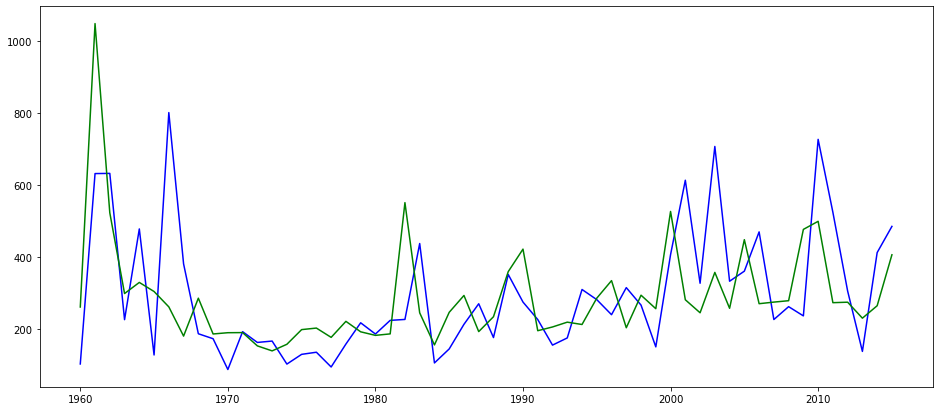

In [117]:
def reg_predict(X,y, window_length):
    coefficients = pd.DataFrame(0, index = ['Year']+X.columns.to_list(), columns=range(1950,1985))
    predictions = []

    X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)

    for target_vintage in range(1950+window_length,2016):
        oldest_vintage = target_vintage - window_length
        newest_vintage = target_vintage

        y_ex = y.loc[oldest_vintage:newest_vintage-1,'Log Price'].reset_index(drop=True)
        X_ex = X.loc[oldest_vintage:newest_vintage-1,:].reset_index()

        target = X.loc[target_vintage,:]
        model.fit(X_ex,y_ex)
        
        target = np.array([target_vintage]+target.to_list()).reshape(1,-1)
        prediction = model.predict(target)
        predictions.append(prediction)
    return predictions
    
window_length = 10
plt.figure(figsize=(16,7))
plt.plot(range(1950+window_length,2016), np.exp(reg_predict(X,y, window_length)), color='blue')
sns.lineplot(data=np.exp(y.loc[1950+window_length:2015,'Log Price']), color='green')
plt.show()


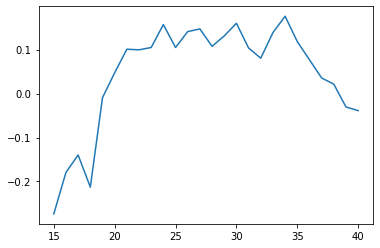

Maximal score:  0.17596739820613772


In [175]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

scores=[]
other_scores=[]

for window_length in range(15,41,1):
    prediction = np.exp(reg_predict(X,y, window_length))
    prediction = np.array(prediction.reshape(1,-1).tolist()[0][-26:]).reshape(1,-1)[0]
    actual_prices = np.exp(y.loc[1990:2015,'Log Price']).values
    scores.append(r2_score(actual_prices, prediction))
    
plt.plot(range(15,41,1),scores)
plt.show()
print('Maximal score: ',max(scores))

# Appendix: Trying PCA

In [15]:
X = pd.concat([precipitations, insulation, temp_maximals, temp_minimals, frost_days], axis=1)

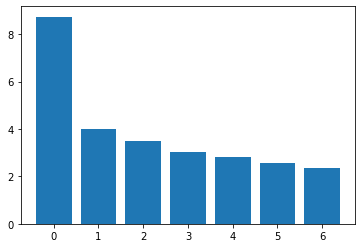

[[ 4.46731803e-02  5.17589182e-02  7.68975089e-02 -5.94249058e-02
   4.73626417e-02 -9.28140490e-05  3.89596387e-02  4.22997508e-02
   2.11402361e-02 -3.24997756e-02 -6.72006048e-02 -3.41858928e-02
  -4.45703682e-02 -9.89856327e-02 -1.30640072e-01 -2.14537934e-01
  -1.44879073e-01 -2.01771935e-01 -1.98760278e-01 -1.54932170e-01
  -2.21329116e-01 -1.16302429e-01 -1.27579706e-01 -1.61126725e-01
  -1.48999490e-01 -9.60686408e-02 -1.02811949e-01 -1.91734605e-01
  -2.28765688e-01 -2.36043014e-01 -2.70261378e-01 -2.32894443e-01
  -2.62187309e-01 -1.65548932e-01 -2.12939355e-01 -2.03097049e-01
  -1.64632403e-01  4.87585185e-02  8.96034355e-02  1.99039602e-01
   1.74983299e-01  3.54514845e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.97248813e-02  1.98930833e-01
   1.39014013e-01]
 [-3.33357461e-01 -2.06877894e-01 -2.04343223e-01 -3.04329665e-02
  -2.49417976e-01  3.01271698e-02  1.50322150e-01 -4.12779228e-03
   1.44561801e-02  1.52068639e-01  3.15252123e-02  3.4539

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA(n_components=7)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

pipeline.fit(X.dropna(axis=0))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.show()
print(pca.components_)

X = X.dropna(axis=0)
X2 = pd.DataFrame(pca.transform(X), index=X.index)

,Year,0,1,2,3,4,5,6
1950,-0.335980,-0.416463,-0.009163,0.136159,0.105901,0.001250,-0.168499,-0.183572
1951,-0.267984,-0.546725,-0.012335,0.262366,0.062584,0.050812,-0.130257,-0.287595
1952,-0.226091,-0.535634,0.036915,0.207841,0.083022,0.031617,-0.183495,-0.261828
1953,-0.290594,-0.536697,-0.012315,0.231973,0.054969,0.058668,-0.160507,-0.216451
1954,-0.263965,-0.493980,0.012876,0.184624,0.032799,0.096273,-0.231274,-0.161149


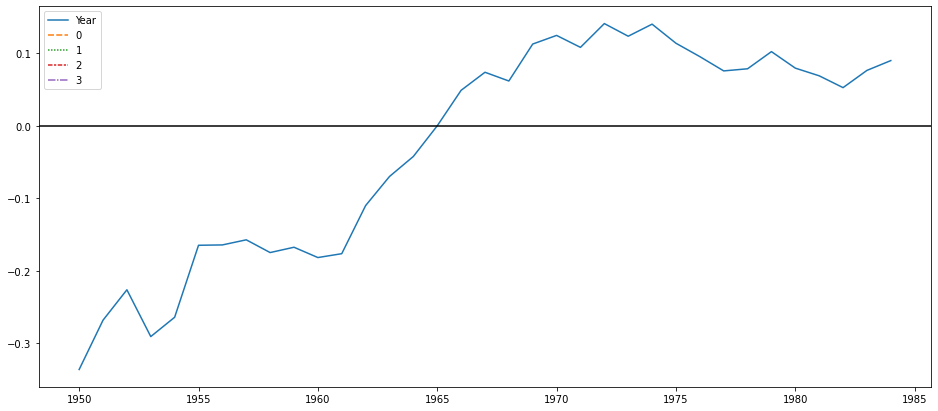

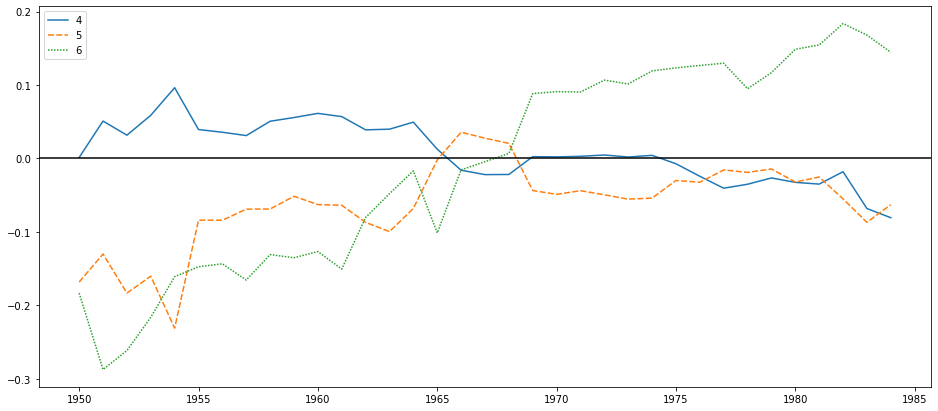

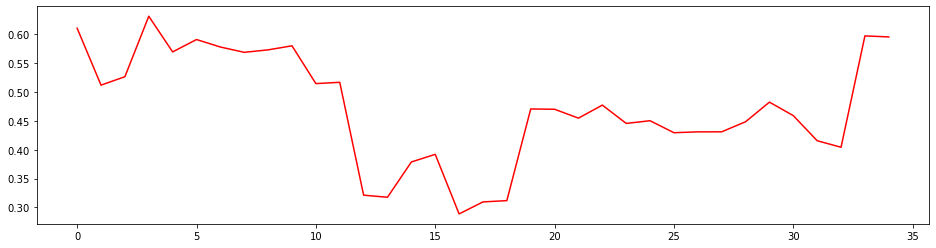

Average score over the whole period:  0.47302570406415184


In [17]:
coefficients, scores = model_tester(X2,y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,:5]).axhline(0., color='black')
plt.show()

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,5:]).axhline(0., color='black')
plt.show()
   
plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.show()
print('Average score over the whole period: ',np.mean(scores))